## Final Project Submission

Please fill out:
* Student name: Wesley Yu
* Student pace: Flex
* Scheduled project review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Tanzanian Water Well Analysis

**Authors:** Wesley Yu
***

## Overview

This notebook will go over modeling process for classifying water well functionality.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from scipy.stats import randint as sp_randInt
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve

In [2]:
# bring in cleaned data
data = pd.read_csv('Data/cleaned_df.csv')

In [3]:
data.head()

,amount_tsh,funder,installer,basin,district_code,lga,public_meeting,permit,extraction_type_group,management,payment,quality_group,quantity,source_type,waterpoint_type,status_group,pop_bins,construct_bins
0,1.0,other,other,Lake Nyasa,5,Ludewa,True,False,gravity,vwc,pay annually,good,enough,spring,communal standpipe,functional,below_average,90s
1,0.0,other,other,Lake Victoria,2,Serengeti,True,True,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,above_average,10s
2,1.0,other,other,Pangani,4,Simanjiro,True,True,gravity,vwc,pay per bucket,good,enough,dam,communal standpipe multiple,functional,above_average,00s
3,0.0,Unicef,other,Ruvuma / Southern Coast,63,Nanyumbu,True,True,submersible,vwc,never pay,good,dry,borehole,communal standpipe multiple,non functional,below_average,80s
4,0.0,other,other,Lake Victoria,1,Karagwe,True,True,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,none,unknown


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   installer              59400 non-null  object 
 3   basin                  59400 non-null  object 
 4   district_code          59400 non-null  int64  
 5   lga                    59400 non-null  object 
 6   public_meeting         59400 non-null  bool   
 7   permit                 59400 non-null  bool   
 8   extraction_type_group  59400 non-null  object 
 9   management             59400 non-null  object 
 10  payment                59400 non-null  object 
 11  quality_group          59400 non-null  object 
 12  quantity               59400 non-null  object 
 13  source_type            59400 non-null  object 
 14  waterpoint_type        59400 non-null  object 
 15  st

In [3]:
# assigning features and target
X = data.drop('status_group', axis = 1)
y = data.status_group

Changing status group to binary. 
* functional = 0
* non funcation = 1

In [4]:
y.replace({'functional': 0, 'non functional': 1}, inplace = True)

In [7]:
y.value_counts()

0    36576
1    22824
Name: status_group, dtype: int64

Creating pipeline for preprocessing steps. Most features are categorical, numeric features have already been changed to either binary or ordinal. Other preprocessing steps can be added if needed.

In [5]:
cat_cols = list(X.select_dtypes('object').columns)

In [6]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [7]:
CT = ColumnTransformer(transformers=[('ohe', ohe, cat_cols)],
                                       remainder='passthrough')

Splitting data to train and test sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model

For our baseline model we will a logistic regression model and optimize for precision. We want to keep the number of false positives low, so that unnecessary resources will not be wasted if a water point was predicted to be non functional but it was in fact functional. We will also monitor recall to ensure we are identifying a good amount of non functional water points.

In [12]:
logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(class_weight = 'balanced', random_state=42, max_iter = 700))])

In [13]:
cv = cross_validate(logreg_model_pipe, X_train, y_train, cv = 5, scoring = ['precision', 'recall'])

In [14]:
cv['test_precision'].mean()

0.7366979730065301

In [15]:
cv['test_recall'].mean()

0.7367891258490648

In [16]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('logreg',
                 Lo

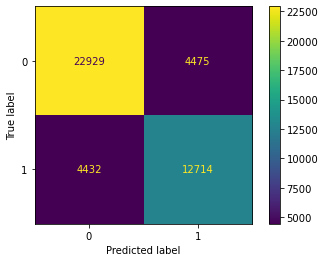

In [17]:
plot_confusion_matrix(logreg_model_pipe, X_train, y_train);

Baseline logistic regression performed decently. Around 73% precision (4475 false positives) of the model's positive predictions were correct and around 73% recall (4432 false negatives) of the total actual positives were correctly predicted. We will see if we can get better results by tuning some hyper parameters. Using gridsearchcv we will try different combinations of solvers and amounts of regulation(C).

In [18]:
params = {"logreg__C": [0.01, 0.1, 1],
          "logreg__solver": ['lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=logreg_model_pipe,
                 param_grid=params,
                 cv=5,
                 scoring = ['precision', 'recall'],
                 refit = 'precision'
                 )

In [19]:
gs.fit(X_train, y_train)

C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\skle

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['funder',
                                                                          'installer',
                                                                          'basin',
                                                                          'lga',
                                                                          'extraction_type_group',
                                                                          'management',
                                    

In [20]:
gs.best_params_

{'logreg__C': 0.1, 'logreg__solver': 'saga'}

In [21]:
gs.best_score_

0.7442428285589741

In [22]:
i = gs.best_index_
gs.cv_results_['mean_test_recall'][i]

0.7264076684292015

Best hyper parameters were found to be solver = saga and C = 0.1. With a precision score of 0.7442.

In [23]:
logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(class_weight = 'balanced', random_state=42, max_iter = 700, solver = 'saga', C = 0.1))])

In [24]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('logreg',
                 Lo

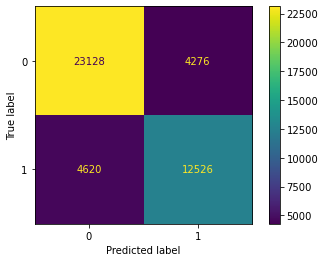

In [25]:
plot_confusion_matrix(logreg_model_pipe, X_train, y_train);

Confusion matrix shows that we have reduced false positives from 4475 to 4276.

## Other classification algorithms
### Decision tree
Based on our features a decision tree model may be able to out perform a logistic regression model due to the majority of categorical features.

In [26]:
dt = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
dt_model_pipe = Pipeline([('ct', CT), ('dt', dt)])

In [27]:
cv = cross_validate(dt_model_pipe, X_train, y_train, cv = 5, scoring = ['precision', 'recall'])

In [28]:
cv['test_precision'].mean()

0.7535421268016254

In [29]:
cv['test_recall'].mean()

0.7686918216855545

In [30]:
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('dt',
                 Decisi

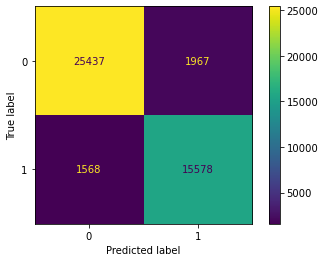

In [31]:
plot_confusion_matrix(dt_model_pipe, X_train, y_train);

Decision tree model performed better than tuned logistic regression model. there is a decrease in false positives (4475 to 1967) and negatives (4620 to 1568), and an increase in true positives (12526 to 15578).

### Random forest
Instead of tuning decision tree parameters for better performance. We can use random forest, which performs multiple decision trees and aggregates their results.

In [32]:
rfc = RandomForestClassifier(random_state=42, class_weight = 'balanced')
rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [33]:
cv = cross_validate(rfc_model_pipe, X_train, y_train, cv = 5, scoring = ['precision', 'recall'])

In [34]:
cv['test_precision'].mean()

0.7996838047831425

In [35]:
cv['test_recall'].mean()

0.761343097418945

In [36]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('rfc',
                 Rando

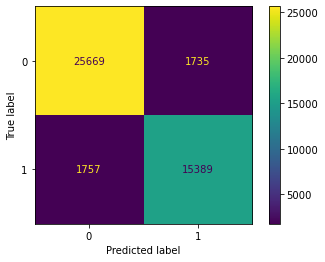

In [37]:
plot_confusion_matrix(rfc_model_pipe, X_train, y_train);

In [38]:
pred_prob = rfc_model_pipe.predict_proba(X_train)

In [39]:
precision, recall, threshold = precision_recall_curve(y_train, pred_prob[:, 1])

In [41]:
pred_prob[:,1]

array([0.91361937, 0.        , 0.00682857, ..., 0.99      , 0.        ,
       1.        ])

Text(0.5, 1.0, 'Precision-Recall Curve')

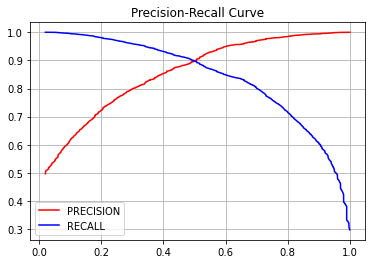

In [42]:
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')

Random forest model much better in terms of precision compared to decision tree model. False positives decreased from 1406 to 1089, while true positives suffered a small amount 15578 to 15389.

#### Random Search CV

## F1

In [43]:
random_grid = {"rfc__n_estimators": sp_randInt(100, 300),
               "rfc__criterion": ["gini", "entropy"],
               "rfc__max_features": ['sqrt', 'log2', None],
               "rfc__min_samples_split": sp_randInt(2, 20),
               "rfc__max_depth": sp_randInt(2, 20),
               "rfc__min_samples_leaf": sp_randInt(2, 20)}

rf_random = RandomizedSearchCV(estimator = rfc_model_pipe, param_distributions = random_grid, n_iter = 50, cv = 5, random_state=42, scoring = ['f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')

In [44]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['funder',
                                                                                'installer',
                                                                                'basin',
                                                                                'lga',
                                                                                'extraction_type_group',
                                                          

In [45]:
rf_random.best_score_

0.7751193126830734

In [46]:
rf_random.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 18,
 'rfc__max_features': None,
 'rfc__min_samples_leaf': 7,
 'rfc__min_samples_split': 6,
 'rfc__n_estimators': 215}

In [47]:
rf_random.cv_results_['params'][46]

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 2,
 'rfc__max_features': 'log2',
 'rfc__min_samples_leaf': 17,
 'rfc__min_samples_split': 9,
 'rfc__n_estimators': 234}

In [48]:
rf_random.cv_results_['params'][33]

{'rfc__criterion': 'gini',
 'rfc__max_depth': 18,
 'rfc__max_features': None,
 'rfc__min_samples_leaf': 7,
 'rfc__min_samples_split': 6,
 'rfc__n_estimators': 215}

In [49]:
rf_bestf1 = rf_random.best_estimator_

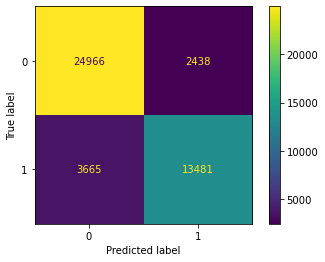

In [50]:
plot_confusion_matrix(rf_bestf1, X_train, y_train);

In [51]:
cv_results_f1 = pd.DataFrame.from_dict(rf_random.cv_results_)

In [52]:
df_f1 = cv_results_f1[['mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 'rank_test_recall']]

In [53]:
df_f1.sort_values(by = 'mean_test_precision', ascending = False)

,mean_test_f1,rank_test_f1,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
7,0.583371,50,0.885149,1,0.435087,50
16,0.583646,47,0.883324,2,0.435845,47
37,0.583646,47,0.883324,2,0.435845,47
42,0.583646,47,0.883324,2,0.435845,47
24,0.696664,32,0.850968,5,0.590166,43
49,0.716173,25,0.837544,6,0.625626,38
35,0.726986,21,0.835593,7,0.643473,33
32,0.673174,42,0.832739,8,0.566545,45
36,0.642664,46,0.831098,9,0.525429,46
21,0.721419,22,0.829477,10,0.638399,34


In [54]:
pred_prob = rf_bestf1.predict_proba(X_train)

precision, recall, threshold = precision_recall_curve(y_train, pred_prob[:, 1])

Text(0.5, 1.0, 'Precision-Recall Curve')

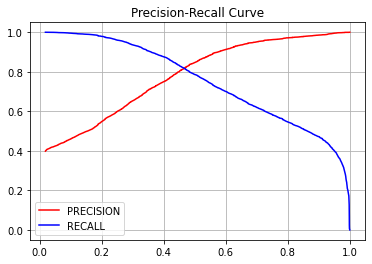

In [55]:
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')

In [269]:
importances = rf_bestf1.steps[1][1].feature_importances_

In [270]:
features = rf_bestf1['ct'].get_feature_names()

In [271]:
ohe_list = []
for i in range(10,13):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

In [272]:
dic = {}
for i in range(0, 3):
    key = ohe_list[i]
    value = cat_cols[i+10]
    dic[key] = value

In [273]:
feature_df = pd.Series(features)

In [274]:
feature_df.replace(dic, regex = True, inplace = True)

In [275]:
ohe_list = []
for i in range(0,10):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

dic = {}
for i in range(0, 10):
    key = ohe_list[i]
    value = cat_cols[i]
    dic[key] = value

In [276]:
feature_df.replace(dic, regex = True, inplace = True)

In [277]:
features_prefix = list(feature_df)

In [278]:
indices = np.argsort(importances)

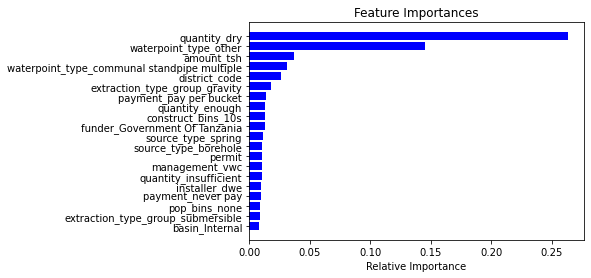

In [280]:
num_features = 20
plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features_prefix[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [201]:
rf_random.cv_results_['params'][7]

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 3,
 'rfc__max_features': None,
 'rfc__min_samples_leaf': 8,
 'rfc__min_samples_split': 13,
 'rfc__n_estimators': 107}

In [58]:
rfc = RandomForestClassifier(random_state=42, class_weight = 'balanced', criterion = 'entropy', max_depth = 3, max_features = None, min_samples_leaf = 8, min_samples_split = 13, n_estimators = 107)
rfc_bestp = Pipeline([('ct', CT), ('rfc', rfc)])
rfc_bestp.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('rfc',
                 Rando

In [59]:
pred_prob = rfc_bestp.predict_proba(X_train)

precision, recall, threshold = precision_recall_curve(y_train, pred_prob[:, 1])

Text(0.5, 1.0, 'Precision-Recall Curve')

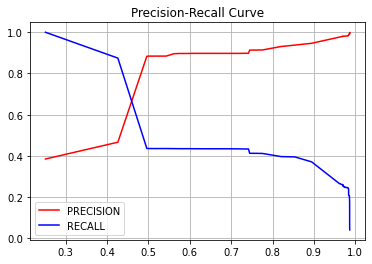

In [60]:
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')

In [209]:
importances = rfc_bestp.steps[1][1].feature_importances_

In [210]:
features = rfc_bestp['ct'].get_feature_names()

In [ ]:
ohe_list = []
for i in range(10,13):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

dic = {}
for i in range(0, 3):
    key = ohe_list[i]
    value = cat_cols[i+10]
    dic[key] = value

In [244]:
feature_df = pd.Series(features)

In [251]:
feature_df.replace(dic, regex = True, inplace = True)

In [248]:
ohe_list = []
for i in range(0,10):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

In [250]:
dic = {}
for i in range(0, 10):
    key = ohe_list[i]
    value = cat_cols[i]
    dic[key] = value

In [ ]:
feature_df.replace(dic, regex = True, inplace = True)

In [252]:
features_prefix = list(feature_df)

In [255]:
indices = np.argsort(importances)

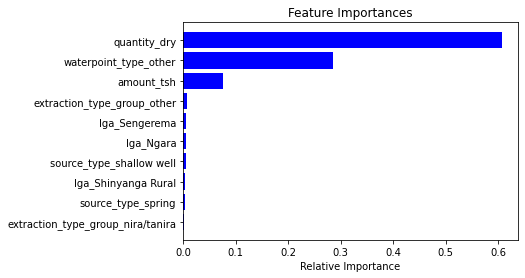

In [256]:
num_features = 10
plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features_prefix[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost 

In [10]:
xgb = XGBClassifier(random_state = 42)
xgb_model_pipe = Pipeline([('ct', CT), ('xgb', xgb)])

In [282]:
cv = cross_validate(xgb_model_pipe, X_train, y_train, cv = 5, scoring = ['precision', 'recall'])

In [283]:
cv['test_precision'].mean()

0.8640172447953635

In [284]:
cv['test_recall'].mean()

0.6812662532829654

In [69]:
xgb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('xgb',
                 XGBCl

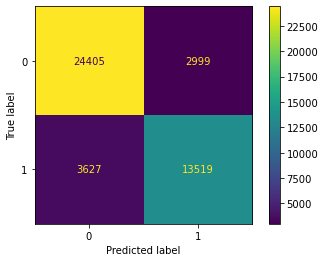

In [70]:
plot_confusion_matrix(xgb_model_pipe, X_train, y_train);

In [285]:
params = {"xgb__scale_pos_weight": [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]}

gs = GridSearchCV(estimator=xgb_model_pipe,
                 param_grid=params,
                 cv=5,
                 scoring = ['precision', 'recall'],
                 refit = 'precision'
                 )

In [286]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['funder',
                                                                          'installer',
                                                                          'basin',
                                                                          'lga',
                                                                          'extraction_type_group',
                                                                          'management',
                                    

In [287]:
gs.best_params_

{'xgb__scale_pos_weight': 0.7}

In [288]:
gs.best_score_

0.8990384731584067

In [75]:
xgb_gs = gs.best_estimator_

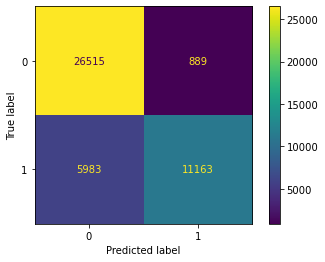

In [76]:
plot_confusion_matrix(xgb_gs, X_train, y_train);

In [11]:
random_grid = {"xgb__n_estimators": sp_randInt(100, 300),
               "xgb__subsample": [0.6, 0.8, 1.0],
               "xgb__colsample_bytree": [0.6, 0.8, 1.0],
               "xgb__learning_rate": [0.05, 0.10, 0.20],
               "xgb__gamma": [0.5, 1, 5],
               "xgb__max_depth": sp_randInt(2, 20),
               "xgb__min_child_weight": sp_randInt(1, 10)}

xgb_random = RandomizedSearchCV(estimator = xgb_model_pipe, param_distributions = random_grid, n_iter = 50, cv = 5, random_state=42, scoring = ['f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')

In [12]:
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['funder',
                                                                                'installer',
                                                                                'basin',
                                                                                'lga',
                                                                                'extraction_type_group',
                                                          

In [13]:
xgb_random.best_score_

0.7872610716134794

In [15]:
xgb_random.best_params_

{'xgb__colsample_bytree': 0.8,
 'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 19,
 'xgb__min_child_weight': 7,
 'xgb__n_estimators': 258,
 'xgb__subsample': 0.8}

In [14]:
cv_results_f1 = pd.DataFrame.from_dict(xgb_random.cv_results_)

df_f1 = cv_results_f1[['mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 'rank_test_recall']]

df_f1.sort_values(by = 'mean_test_precision', ascending = False)

,mean_test_f1,rank_test_f1,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
36,0.694751,48,0.884746,1,0.571969,48
23,0.725160,44,0.883631,2,0.614953,47
27,0.669279,49,0.882343,3,0.539134,49
46,0.667035,50,0.881803,4,0.536451,50
5,0.738791,39,0.877694,5,0.637932,41
22,0.752627,31,0.876508,6,0.659454,34
14,0.748287,35,0.876108,7,0.653096,37
17,0.730521,42,0.875548,8,0.626793,42
43,0.772593,16,0.875386,9,0.691473,21
8,0.756250,28,0.873761,10,0.666685,30


In [16]:
xgb_bestf1 = xgb_random.best_estimator_

In [17]:
pred_prob = xgb_bestf1.predict_proba(X_train)

precision, recall, threshold = precision_recall_curve(y_train, pred_prob[:, 1])

Text(0.5, 1.0, 'Precision-Recall Curve')

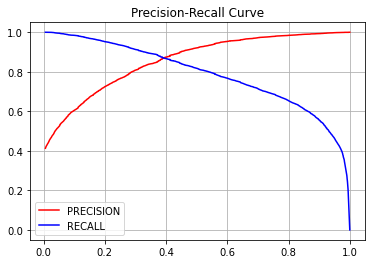

In [18]:
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')

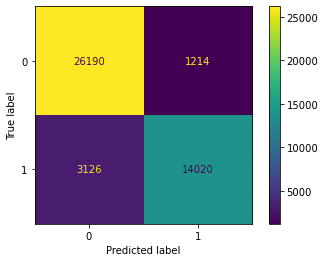

In [19]:
plot_confusion_matrix(xgb_bestf1, X_train, y_train);

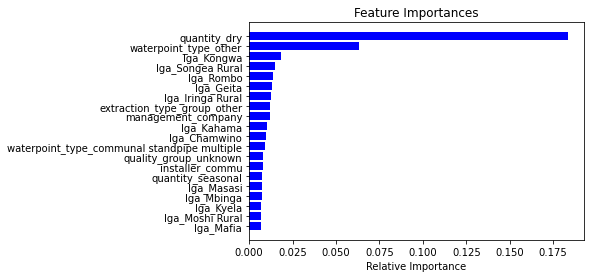

In [20]:
importances = xgb_bestf1.steps[1][1].feature_importances_

features = xgb_bestf1['ct'].get_feature_names()

ohe_list = []
for i in range(10,13):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

dic = {}
for i in range(0, 3):
    key = ohe_list[i]
    value = cat_cols[i+10]
    dic[key] = value

feature_df = pd.Series(features)

feature_df.replace(dic, regex = True, inplace = True)

ohe_list = []
for i in range(0,10):
    key = 'ohe__x'+str(i)
    ohe_list.append(key)

dic = {}
for i in range(0, 10):
    key = ohe_list[i]
    value = cat_cols[i]
    dic[key] = value

feature_df.replace(dic, regex = True, inplace = True)

features_prefix = list(feature_df)

indices = np.argsort(importances)

num_features = 20
plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features_prefix[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

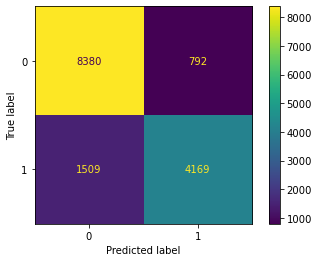

In [21]:
plot_confusion_matrix(xgb_bestf1, X_test, y_test);

In [23]:
prt = pd.DataFrame([precision, recall, threshold])

In [25]:
prt.T

,0,1,2
0,0.413017,1.000000,0.006029
1,0.413851,0.999942,0.006037
2,0.413861,0.999942,0.006064
3,0.413950,0.999942,0.006077
4,0.413960,0.999942,0.006084
...,...,...,...
17833,1.000000,0.000875,0.999966
17834,1.000000,0.000817,0.999973
17835,1.000000,0.000583,0.999975
17836,1.000000,0.000058,0.999976
